# Klasifikasi Gambar Tiga Kelas - CNN
# Dataset : Rockpaperscissors
# By Muhammad Fadli Rahmat
# Email : fadli.rahmat@sbm-itb.ac.id

In [62]:
#import modul-modul yang dibutuhkan
import tensorflow as tf
import keras.preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import zipfile

In [3]:
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

--2021-06-10 02:40:12--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  1.35MB/s    in 5m 11s  

2021-06-10 02:45:24 (1015 KB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



In [4]:
#baca file zip, lalu extract
local_zip = '/tmp/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [5]:
#liat isi file zip yang telah diextract
os.listdir('/tmp')

['initgoogle_syslog_dir.0',
 '__MACOSX',
 'debugger_hne20gn6k',
 'rockpaperscissors',
 'dap_multiplexer.284941fc050c.root.log.INFO.20210610-023944.50',
 'rockpaperscissors.zip',
 'dap_multiplexer.INFO']

In [6]:
#tentukan lokasi dataset
os.listdir('/tmp/rockpaperscissors')

['paper', 'README_rpc-cv-images.txt', 'rps-cv-images', 'scissors', 'rock']

In [7]:
#tentukan lokasi dataset
os.listdir('/tmp/rockpaperscissors/rps-cv-images')

['paper', 'README_rpc-cv-images.txt', 'scissors', 'rock']

In [8]:
#deklarasi lokasi file/dir yang akan dijadikan base
base_dir = '/tmp/rockpaperscissors/rps-cv-images'

In [9]:
os.listdir(base_dir)

['paper', 'README_rpc-cv-images.txt', 'scissors', 'rock']

In [56]:
#Melakukan Augmentasi dan Membagi dataset jadi training dan validation data
train_datagen = ImageDataGenerator(
    rescale=1./255,                                                               #rescaling factor. Defaults to None 
    rotation_range=20,                                                            #Int. Degree range for random rotations
    horizontal_flip=True,                                                         #Boolean. Randomly flip inputs horizontally
    shear_range=0.2,                                                              #Float. Shear Intensity (Shear angle in counter-clockwise direction in degrees)
    fill_mode='nearest',                                                          #pilih antara nearest(default)/constant/reflect/wrap
    validation_split=0.4)                                                         #validation_split: Float. Fraction of images reserved for validation (strictly between 0 and 1)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150,150),                                                        #tuple of integers (height, width), default: (256, 256). The dimensions to which all images found will be resized.
    batch_size=32,                                                                 #size of the batches of data (default: 32)
    class_mode='categorical',                                                     #pilih antara categorical(default)/binary/input/multioutput/raw/sparse/None
    shuffle=True,                                                                 #whether to shuffle the data (default: True)
    subset='training')                                                            #Subset of data ("training" or "validation")

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150,150),                                                        #tuple of integers (height, width), default: (256, 256). The dimensions to which all images found will be resized.
    batch_size=32,                                                                 #size of the batches of data (default: 32)
    class_mode='categorical',                                                     #pilih antara categorical(default)/binary/input/multioutput/raw/sparse/None
    shuffle=True,                                                                 #whether to shuffle the data (default: True)
    subset='validation')                                                          #Subset of data ("training" or "validation")

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


In [57]:
#Menyiapkan model jaringan saraf tiruan
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=(150,150,3)), #layer konvolusi pertama, inputshape=ukuran 150x150 dengan 3 byte warna
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),                         #layer konvolusi kedua
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),                        #layer koncolusi ketiga
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),                        #layer konvolusi ketiga
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Flatten(),                                                    #layer input
    tf.keras.layers.Dense(512, activation='relu'),                                #hidden layer pertama
    tf.keras.layers.Dense(512, activation='relu'),                                #hidden layer kedua
    tf.keras.layers.Dense(512, activation='relu'),                                #hidden layer ketiga
    tf.keras.layers.Dense(3, activation='softmax')                                #output layer
])                                                                                #makin banyak layer makin bagus tapi pemprosesannya makin lama

In [58]:
#Melakukan kompilasi model
model.compile(loss='categorical_crossentropy',                                    #binary_crossentropy/categorical_crossentropy/sparse_categorical_crossentropy/poisson/kl_divergence
              optimizer='rmsprop',                                                #SGD/RMSprop/Adam/Adadelta/Adagrad/Adamax/Nadam/Ftrl
              metrics=['accuracy'])                                               #Accuracy/Probabilistic/Regression/Classification

In [59]:
# Membuat class callback, yang berisi fungsi on_epoch_end >> memberhentikan proses training saat accuracy yang sudah ditentukan tercapai, agar cepat dan gak turun lagi
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>=0.95 and logs.get('accuracy')>=0.95):                                            #training berhenti saat val_accuracy>95%
      print("\nTraining stop, Target Achieved!")
      self.model.stop_training = True

callbacks = myCallback()

In [60]:
#Mulai pelatihan
model.fit(
    train_generator,
    steps_per_epoch=41,                                                           #Integer or None. Total number of steps (batches of samples) before declaring one epoch finished
    epochs=25,                                                                    #Integer. Number of epochs to train the model
    validation_data=validation_generator,
    validation_steps=27,                                                          #Total number of steps (batches of samples) to draw before stopping when performing validation at the end of every epoch.
    verbose=2,                                                                    #'auto', 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. 'auto' defaults to 1 for most cases
    callbacks=[callbacks]                                                         #List of callbacks to apply during training, stop when?
)

Epoch 1/25
41/41 - 140s - loss: 1.1076 - accuracy: 0.3838 - val_loss: 1.0842 - val_accuracy: 0.3310
Epoch 2/25
41/41 - 76s - loss: 0.8937 - accuracy: 0.6264 - val_loss: 0.3516 - val_accuracy: 0.8738
Epoch 3/25
41/41 - 78s - loss: 0.4480 - accuracy: 0.8308 - val_loss: 0.5891 - val_accuracy: 0.7766
Epoch 4/25
41/41 - 77s - loss: 0.3351 - accuracy: 0.8775 - val_loss: 0.4372 - val_accuracy: 0.8356
Epoch 5/25
41/41 - 77s - loss: 0.2441 - accuracy: 0.9212 - val_loss: 0.1704 - val_accuracy: 0.9502
Epoch 6/25
41/41 - 76s - loss: 0.1652 - accuracy: 0.9524 - val_loss: 0.2537 - val_accuracy: 0.9329
Epoch 7/25
41/41 - 76s - loss: 0.1997 - accuracy: 0.9360 - val_loss: 0.1073 - val_accuracy: 0.9641
Epoch 8/25
41/41 - 76s - loss: 0.3363 - accuracy: 0.8580 - val_loss: 0.1121 - val_accuracy: 0.9664
Epoch 9/25
41/41 - 77s - loss: 0.1644 - accuracy: 0.9444 - val_loss: 0.1323 - val_accuracy: 0.9676
Epoch 10/25
41/41 - 76s - loss: 0.1660 - accuracy: 0.9587 - val_loss: 0.0805 - val_accuracy: 0.9711

Trainin

Saving IMG20210610124925.jpg to IMG20210610124925.jpg
IMG20210610124925.jpg
scissors


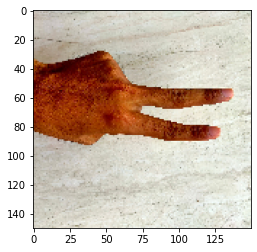

In [70]:
#Mengecek model dengan data baru
uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)

  print(fn)
  if classes[0,0]!=0:
    print('paper')
  elif classes[0,1]!=0:
    print('rock')
  else:
    print('scissors')